# Transformations in Time Series Forecasting

This tutorial introduces one of the most powerful features of sktime: transformations. In many situations, we need to change the timeseries data to enforce certain characteristics, or we need to create features that our model can use to improve the performance. We will be focusing on various transformation techniques that can be applied to time series data, focusing particularly on forecasting task, but all the transformations shown in this tutorial are applicable to other types of time series analysis as well.

One the benefits of using sktime is that transformations are **modular**. This means that you can easily combine and reuse different transformations to create a customized preprocessing pipeline for your specific forecasting task.

**Duration:** ~10 minutes

## Learning objectives

By the end of this tutorial, you will be able to:
- Understand the motivation for time series transformations
- Apply transformations to the target timeseries, such as log, differencing, and detrending
- Create features using transformations
- Combine multiple transformations effectively

## 1. Loading the dataset

In this tutorial, we will use the `AirPassengers` dataset, that we have also used in univariate timeseries tutorial.

Let's load the dataset and visualize it.

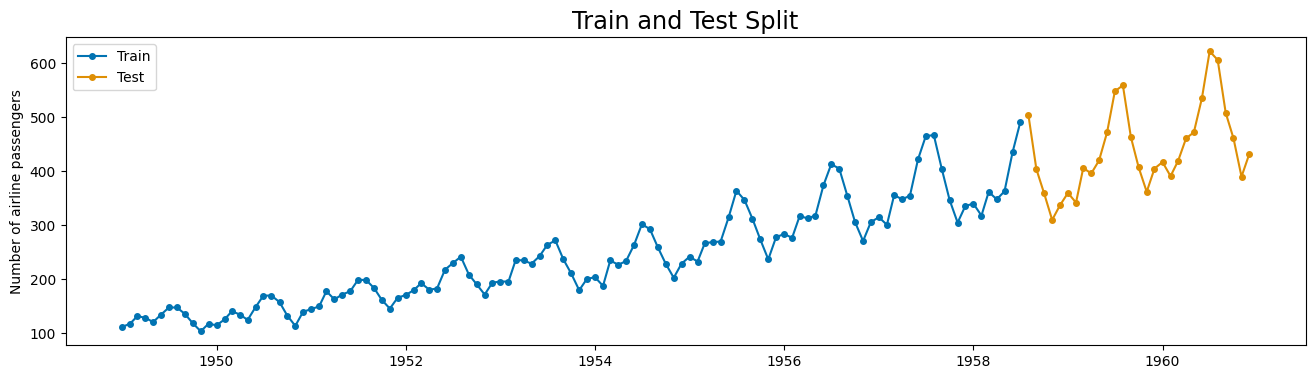

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sktime.datasets import Airline
from sktime.split.temporal_train_test_split import temporal_train_test_split
from sktime.utils.plotting import plot_series

# Load airline dataset for demonstration
y = Airline().load("y")

y_train, y_test = temporal_train_test_split(y, test_size=0.2)
# Plot the training and testing data
plot_series(y_train, y_test, labels=["Train", "Test"], title="Train and Test Split")
plt.show()

Transformations can be separated into two: those applied to the target variables `y` and those applied to the features `X`. We will see in the following sections that, although their usage differs, both transformations have the same crucial API:

* `fit(X, y=None)`: Fit the transformation to the data.
* `transform(X, y=None)`: Apply the transformation to the data.
* `inverse_transform(X, y=None)`: Reverse the transformation (if applicable).


## 2. Target Variable Transformations




### 2.1 Basic usage

We start by instantiating a simple differencing transformation.

In [2]:
from sktime.transformations.series.difference import Differencer

# Create differencing transformer
differencer = Differencer(lags=1)  # First difference
differencer

Differencer()

They follow the same estimator API as scikit-learn and sktime estimators, in the sense that hyperparameters are set during initialization, and they can be changed and retrieved by using the `set_params` and `get_params` methods.


In [3]:
differencer.get_params()

{'lags': 1, 'memory': 'all', 'na_handling': 'fill_zero'}

To apply the transformation, we first fit it to the training data and then transform the data.


In [4]:
differencer = differencer.fit(y_train)
y_train_transformed = differencer.transform(y_train)

Obs: one shortcut to apply both fit and predict is calling `fit_transform`.

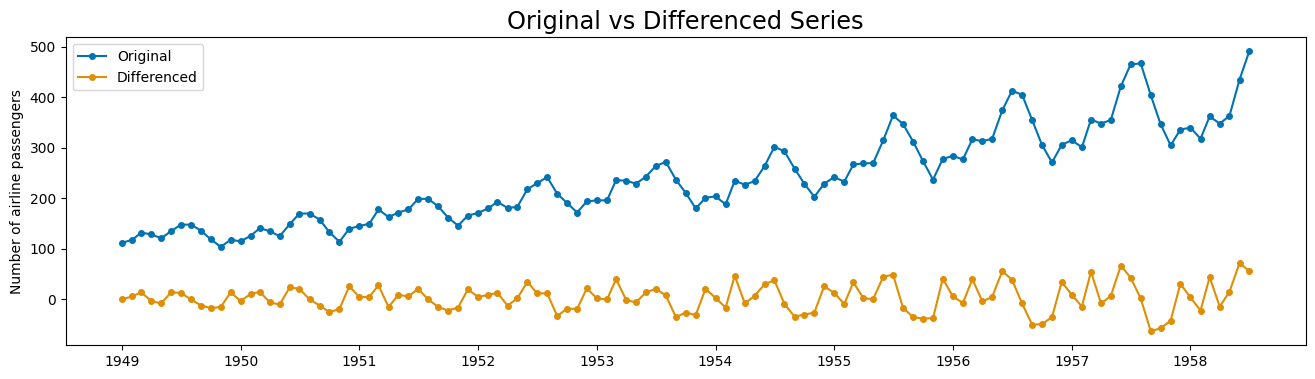

In [5]:
plot_series(
    y_train,
    y_train_transformed,
    labels=["Original", "Differenced"],
    title="Original vs Differenced Series",
)
plt.show()

Another common transformation is the logarithmic transformation. It is particularly useful when the timeseries show multiplicative seasonality - which is the case for the Airline dataset.


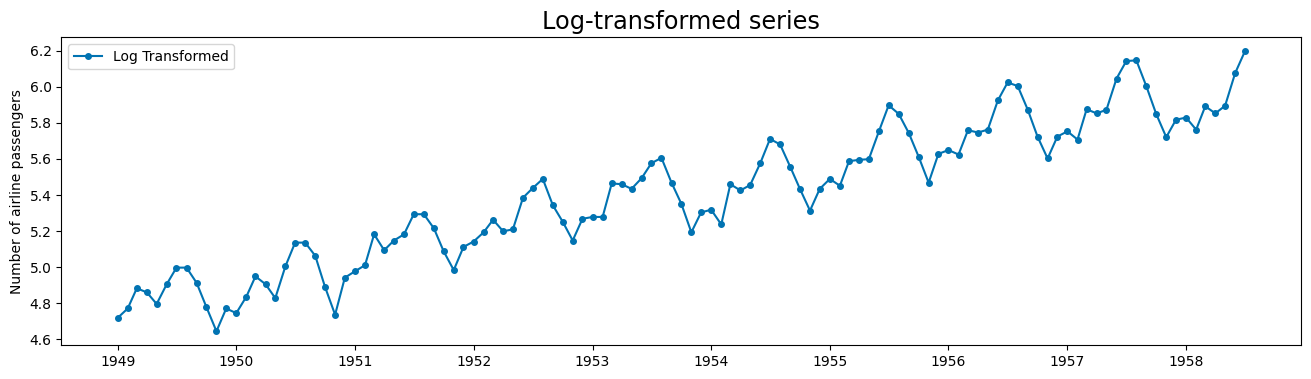

In [6]:
from sktime.transformations.series.boxcox import LogTransformer

y_train_transformed_log = LogTransformer().fit_transform(y_train)

plot_series(
    y_train_transformed_log, labels=["Log Transformed"], title="Log-transformed series"
)
plt.show()

As you can see, the variation of the timeseries is stabilized after the logarithmic transformation.

### 2.2 Composing transformations

One interesting use-case is applying multiple transformations in sequence. For example, we can first apply a logarithmic transformation to stabilize the variance and then apply differencing to remove the remaining trend.

There is a `TransformerPipeline` class in sktime that allows you to chain multiple transformations together.


In [7]:
from sktime.transformations.compose import TransformerPipeline

transformation_pipeline = TransformerPipeline(
    steps=[("log", LogTransformer()), ("diff", Differencer())]
)

transformation_pipeline

TransformerPipeline(steps=[('log', LogTransformer()), ('diff', Differencer())])

The API is always the same: fit, and transform. One shortcut to chain transformations is using the `*` operator:

```python
transformation_pipeline = LogTransformer() * Differencer()
```

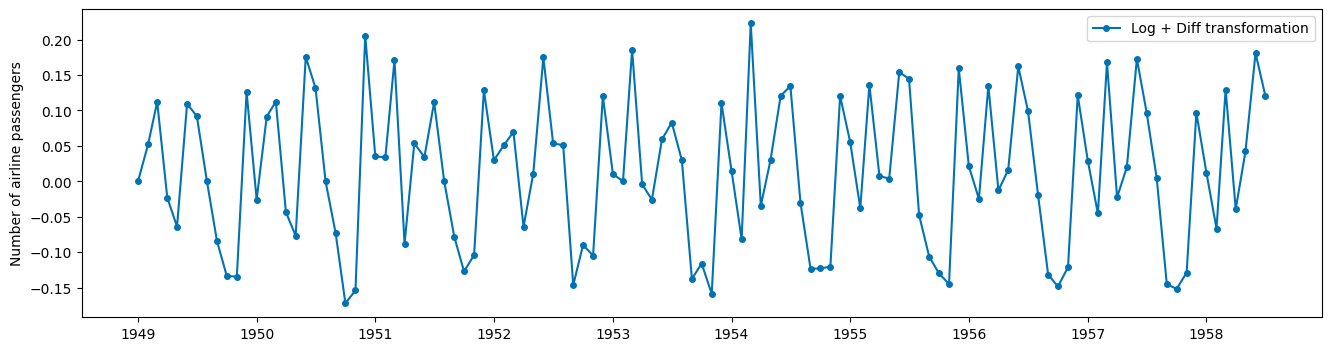

In [8]:
y_train_transformed_pipe = transformation_pipeline.fit_transform(y_train)

plot_series(y_train_transformed_pipe, labels=["Log + Diff transformation"])
plt.show()

When creating pipelines of transformations, it is important to have in mind that they are applied sequentially. This means that the output of one transformation is the input to the next. Therefore, the order of transformations matters, and it is crucial to choose transformations that complement each other.

If you are familiar to scikit-learn, you can also use scikit-learn's transformations with sktime! Take as example the pipeline below that, after applying log and differencing, scales the timeseries using MinMaxScaler.


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

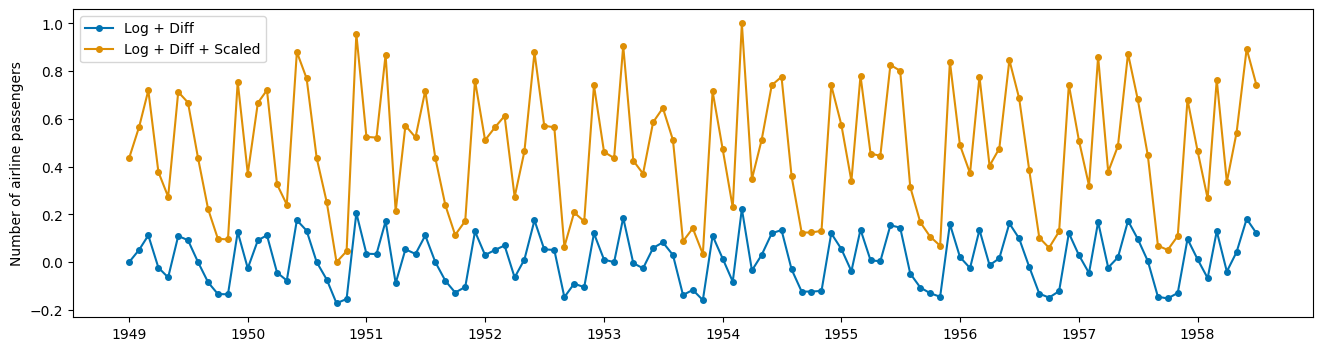

In [9]:
from sklearn.preprocessing import MinMaxScaler

transformation_pipeline = LogTransformer() * Differencer() * MinMaxScaler()

y_train_transformed_pipe_scaled = transformation_pipeline.fit_transform(y_train)

plot_series(
    y_train_transformed_pipe,
    y_train_transformed_pipe_scaled,
    labels=["Log + Diff", "Log + Diff + Scaled"],
)

## 2. Feature Engineering

Besides transforming the target timeseries, we may want to create additional features that help the model learn better, or transform these exogenous variables.

- Lag features
- Rolling window statistics
- Fourier features

We first create an empty dataframe `X` to store the features.

In [10]:
X_train = pd.DataFrame(index=y_train.index)
X_train

""
1949-01
1949-02
1949-03
1949-04
1949-05
...
1958-03
1958-04
1958-05
1958-06


### 2.1. Basic examples

Fourier terms (pairs of sines and cosines with specific frequencies) are a common feature engineering technique used to capture seasonality and periodic patterns in time series data. There is a `FourierFeatures` transformer in sktime that allows you to easily create these features.

The difference here is that we apply the transformation to `X`, and not to `y`. The API is the same, though: fit, and transform.

In [11]:
from sktime.transformations.series.fourier import FourierFeatures

# Create Fourier features for seasonality
fourier_transformer = FourierFeatures(
    sp_list=[12],  # 12-month seasonality
    fourier_terms_list=[3],  # 3 Fourier terms
    keep_original_columns=True,
)

# Fit and transform
fourier_transformer.fit_transform(X_train)

,sin_12_1,cos_12_1,sin_12_2,cos_12_2,sin_12_3,cos_12_3
1949-01,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00,1.000000e+00
1949-02,5.000000e-01,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17
1949-03,8.660254e-01,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00
1949-04,1.000000e+00,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16
1949-05,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00
...,...,...,...,...,...,...
1958-03,8.660254e-01,5.000000e-01,8.660254e-01,-0.5,2.449913e-14,-1.000000e+00
1958-04,1.000000e+00,4.892397e-16,9.784795e-16,-1.0,-1.000000e+00,-1.467719e-15
1958-05,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,-6.858022e-15,1.000000e+00
1958-06,5.000000e-01,-8.660254e-01,-8.660254e-01,0.5,1.000000e+00,1.224832e-14


There are also other transformers to create dummies features, for example:

In [16]:
import pandas as pd

from sktime.transformations.series.holiday import CountryHolidaysTransformer

# Create holiday features
holiday_transformer = CountryHolidaysTransformer(
    "US",
)

holiday_transformer.fit_transform(X_train)

,US_holidays
0,True
1,False
2,False
3,False
4,False
...,...
110,False
111,False
112,False
113,False


### 2.2 Combining transformations

More often than not, a single transformation is not enough. We can combine multiple transformations to create a feature engineering pipeline.
We can use the `*` operator to chain multiple transformations together, as we did with the target transformations.

In [13]:
feature_pipeline = holiday_transformer * fourier_transformer

feature_pipeline.fit_transform(X_train)

,US_holidays,sin_12_1,cos_12_1,sin_12_2,cos_12_2,sin_12_3,cos_12_3
0,True,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00,1.000000e+00
1,False,5.000000e-01,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17
2,False,8.660254e-01,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00
3,False,1.000000e+00,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16
4,False,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00
...,...,...,...,...,...,...,...
110,False,8.660254e-01,5.000000e-01,8.660254e-01,-0.5,2.449913e-14,-1.000000e+00
111,False,1.000000e+00,4.892397e-16,9.784795e-16,-1.0,-1.000000e+00,-1.467719e-15
112,False,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,-6.858022e-15,1.000000e+00
113,False,5.000000e-01,-8.660254e-01,-8.660254e-01,0.5,1.000000e+00,1.224832e-14


### 2.3. Feature selection

Adding features is important, but adding too many features can lead to overfitting and increased computational cost. Therefore, it is crucial to select the most relevant features for the forecasting task.

One way to perform feature selection is by using the `FeatureSelection` transformer in sktime. This transformer can be added to the feature engineering pipeline and will automatically select the most important features based on a specified criterion.

In [17]:
from sklearn.ensemble import RandomForestRegressor

from sktime.transformations.series.feature_selection import FeatureSelection

feature_pipeline = feature_pipeline * FeatureSelection(
    method="feature-importances", regressor=RandomForestRegressor()
)

feature_pipeline.fit(X_train, y_train)

TransformerPipeline(steps=[CountryHolidaysTransformer(country='US'),
                           FourierFeatures(fourier_terms_list=[3],
                                           keep_original_columns=True,
                                           sp_list=[12]),
                           FeatureSelection(regressor=RandomForestRegressor()),
                           FeatureSelection(regressor=RandomForestRegressor())])

In [18]:
feature_pipeline.transform(X_train)

,cos_12_1,sin_12_1
0,1.000000e+00,0.000000e+00
1,8.660254e-01,5.000000e-01
2,5.000000e-01,8.660254e-01
3,6.123234e-17,1.000000e+00
4,-5.000000e-01,8.660254e-01
...,...,...
110,5.000000e-01,8.660254e-01
111,4.892397e-16,1.000000e+00
112,-5.000000e-01,8.660254e-01
113,-8.660254e-01,5.000000e-01


This way, as we will see in later tutorials, you can also **backtest the preprocessing pipeline** to find the best set of transformations for your forecasting task. This is a common mistake made by practitioners, who often apply transformations to the entire dataset before backtesting, leading to data leakage and overly optimistic performance estimates.

## Key takeaways

* Transformations are a powerful tool for time series forecasting, allowing you to preprocess and engineer features that can significantly improve model performance.
* Sktime allows you to combine multiple transformations and create a more robust feature engineering pipeline.
* Feature selection is also easy to use, and crucial to avoid overfitting and improve model interpretability.
